Loading intrinsic population
Loading GW population


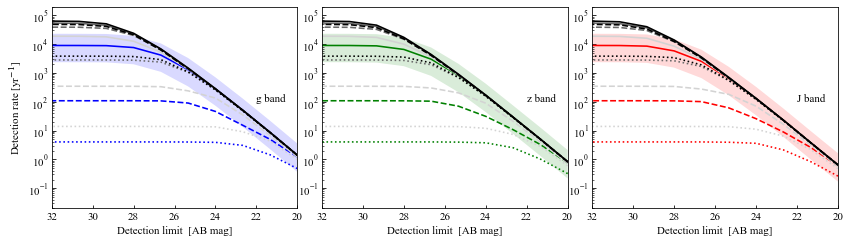

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from functions_ET import *
import warnings
warnings.filterwarnings("ignore")

# --- Parametri ---
num = 1000000
eos = "SFHo"
mns_max = 2.058838

# --- Lettura file HDF5 ---
table = h5py.File(f'../horizons2/population/computed_population/nsns_{num}_{eos}_GWFAST.hdf5', 'r')

print("Loading intrinsic population")
m1 = table['m1'][()]
m2 = table['m2'][()]
z = table['z'][()]
dL = table['dL'][()]
thv = table['thv'][()]
m_dyn = table['m_dyn'][()]
m_disk = table['m_disk'][()]
m_gw = table['m_gw'][()]
E_bkt = table['E_bkt'][()]
E_k_jet = table['E_k_jet'][()]
Ec = table['Ec'][()]
L_sb = table['L_sb'][()]
Eiso_sb = table['Eiso_sb'][()]
Epeak_sb = table['Epeak_sb'][()]
kn_waves = table['kn_waves'][()]
t_kn = table['t_kn'][()]
lc_kn = table['lc_kn'][()]

print("Loading GW population")
snr_ETT = table['snr_ETT'][()]
snr_ETL = table['snr_ETL'][()]
snr_ETT2CE = table['snr_ETT2CE'][()]
snr_ETL2CE = table['snr_ETL2CE'][()]
sky_loc_ETT = table['sky_loc_ETT'][()]
sky_loc_ETL = table['sky_loc_ETL'][()]
sky_loc_ETT2CE = table['sky_loc_ETT2CE'][()]
sky_loc_ETL2CE = table['sky_loc_ETL2CE'][()]
table.close()

# --- Quantità derivate ---
m_rem = m1 + m2 - m_gw - m_disk - m_dyn

# --- Pesi ---
w_thv = np.sin(thv)
w_m1, w_m2 = mass_colombo22(m1, m2)
r0BNS = 347 / 1.85
r0BNS_high = (347 + 536) / 1.85
r0BNS_low = (347 - 256) / 1.85
w_z, w_z_high, w_z_low = redshift_weight(z, r0BNS, r0BNS_high, r0BNS_low)

w = w_m1 * w_m2 * w_z * w_thv
w_high = w_m1 * w_m2 * w_z_high * w_thv
w_low = w_m1 * w_m2 * w_z_low * w_thv

C_mc, C_mc_high, C_mc_low = monte_carlo_normalization(w, w_high, w_low, r0BNS, r0BNS_high, r0BNS_low)

# --- Parametri plot ---
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['figure.figsize'] = 12., 3.5
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
gs = gridspec.GridSpec(1, 3, top=0.95, right=0.98, left=0.07, wspace=0.1, hspace=0.1, bottom=0.15)

# --- Limiti di magnitudine ---
lim_snr = 12.
lim_kn = np.linspace(20., 32., 10)

# --- Ordinamento ---
x = np.sort(z)
s = np.argsort(z)

snr = [snr_ETT, snr_ETL, snr_ETT2CE, snr_ETL2CE]
sky = [sky_loc_ETT, sky_loc_ETL, sky_loc_ETT2CE, sky_loc_ETL2CE]
color_g = ['b', 'lightgrey', 'dimgrey', 'black']
color_z = ['green', 'lightgrey', 'dimgrey', 'black']
color_J = ['red', 'lightgrey', 'dimgrey', 'black']

# --- Loop sugli strumenti GW ---
for k in range(len(snr)):
    gw_snr = snr[k]
    sky_loc = sky[k]
    gw_det = gw_snr >= lim_snr
    kn_peak = np.min(lc_kn, axis=2)
    kn_det = np.zeros([num, len(kn_waves)], dtype=bool)

    det_kn_g = np.zeros(len(lim_kn))
    det_kn_g_low = np.zeros(len(lim_kn))
    det_kn_g_high = np.zeros(len(lim_kn))
    det_kn_g_100 = np.zeros(len(lim_kn))
    det_kn_g_40 = np.zeros(len(lim_kn))
    det_kn_g_10 = np.zeros(len(lim_kn))
    det_kn_z = np.zeros(len(lim_kn))
    det_kn_z_low = np.zeros(len(lim_kn))
    det_kn_z_high = np.zeros(len(lim_kn))
    det_kn_z_100 = np.zeros(len(lim_kn))
    det_kn_z_10 = np.zeros(len(lim_kn))
    det_kn_J = np.zeros(len(lim_kn))
    det_kn_J_low = np.zeros(len(lim_kn))
    det_kn_J_high = np.zeros(len(lim_kn))
    det_kn_J_100 = np.zeros(len(lim_kn))
    det_kn_J_10 = np.zeros(len(lim_kn))

    for i in range(len(lim_kn)):
        for j in range(len(kn_waves)):
            kn_peak_APP = abs_to_app(kn_peak[:, j], dL[:] * 1.e6)
            kn_det[:, j] = kn_peak_APP <= lim_kn[i]

        kn_det_g = kn_det[:, 0]
        kn_det_z = kn_det[:, 1]
        kn_det_J = kn_det[:, 2]

        valid = (m_disk[s] > 1.e-5) | (m_dyn[s] > 1.e-6)

        def cum(w_, det_, loc_cut=None):
            mask = det_[s] * gw_det[s] * valid
            if loc_cut is not None:
                mask = mask * (sky_loc[s] < loc_cut)
            return C_mc * np.cumsum(w_[s] * mask)[-1]

        det_kn_g[i] = cum(w, kn_det_g)
        det_kn_g_low[i] = cum(w_low, kn_det_g)
        det_kn_g_high[i] = cum(w_high, kn_det_g)
        det_kn_g_100[i] = cum(w, kn_det_g, 100)
        det_kn_g_40[i] = cum(w, kn_det_g, 40)
        det_kn_g_10[i] = cum(w, kn_det_g, 10)

        det_kn_z[i] = cum(w, kn_det_z)
        det_kn_z_low[i] = cum(w_low, kn_det_z)
        det_kn_z_high[i] = cum(w_high, kn_det_z)
        det_kn_z_100[i] = cum(w, kn_det_z, 100)
        det_kn_z_10[i] = cum(w, kn_det_z, 10)

        det_kn_J[i] = cum(w, kn_det_J)
        det_kn_J_low[i] = cum(w_low, kn_det_J)
        det_kn_J_high[i] = cum(w_high, kn_det_J)
        det_kn_J_100[i] = cum(w, kn_det_J, 100)
        det_kn_J_10[i] = cum(w, kn_det_J, 10)

    for idx, (band, det, det_100, det_10, det_high, det_low, color, title) in enumerate([
        (0, det_kn_g, det_kn_g_100, det_kn_g_10, det_kn_g_high, det_kn_g_low, color_g[k], "g band"),
        (1, det_kn_z, det_kn_z_100, det_kn_z_10, det_kn_z_high, det_kn_z_low, color_z[k], "z band"),
        (2, det_kn_J, det_kn_J_100, det_kn_J_10, det_kn_J_high, det_kn_J_low, color_J[k], "J band")
    ]):
        plt.subplot(gs[idx])
        plt.plot(lim_kn, det, color=color, ls="-", linewidth=1.6)
        plt.plot(lim_kn, det_100, color=color, ls="--", linewidth=1.6)
        plt.plot(lim_kn, det_10, color=color, ls=":", linewidth=1.6)
        if k == 0:
            plt.fill_between(lim_kn, det_high, det_low, color=color, alpha=0.15, edgecolor="None")
        plt.tick_params(which='both', direction='in', labelsize=11)
        plt.yscale("log")
        plt.xlim((20, 32))
        plt.ylim((2.e-2, 2.e5))
        plt.gca().invert_xaxis()
        if k == 0:
            plt.text(22, 1.e2, title, fontsize=11)
            if idx == 0:
                plt.ylabel(r'Detection rate [yr$^{-1}$]', size=11)
            plt.xlabel(r'Detection limit  [AB mag]', size=11)

plt.show()